Compare two-line fit without uplims with result from ROXY. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from roxy.regressor import RoxyRegressor
import roxy.plotting

import harmonic as hm

import pandas as pd
import jax.numpy as jnp

-0.23953069401384267
1.2469519477630981


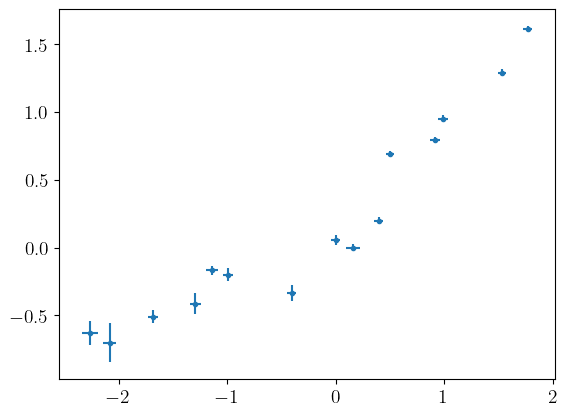

In [18]:
# Use real data

file_name = "./DATA/MAXI J1348-630_paired_Lr_Lx_interp.csv"

df = pd.read_csv(file_name)  # replace with your actual filename

# Extract the desired columns
lx       = df["Lx"].to_numpy()
dlx_l = df["Lx_unc_l"].to_numpy()
dlx_u = df["Lx_unc_u"].to_numpy()
lr       = df["Lr"].to_numpy()
dlr   = df["Lr_unc"].to_numpy()
state = df["state"].to_numpy()
Lx_uplim_bool = df["Fx_uplim_bool"].to_numpy()
Lr_uplim_bool = df["Fr_uplim_bool"].to_numpy()

# Create the mask
mask = ((state == "HS") | (state == "QS")) & (Lx_uplim_bool==False) & (Lr_uplim_bool==False)

# Apply the mask to each array
lx     = lx[mask]
dlx_l  = dlx_l[mask]
dlx_u  = dlx_u[mask]
lr     = lr[mask]
dlr    = dlr[mask]
state  = state[mask]

lx0 = np.median(lx)
lr0 = np.median(lr)

# x:
lx_scaled = lx/lx0
log_lx_scaled = np.log10(lx_scaled) # x
log_dlx_l_scaled = np.log10(lx / (lx - dlx_l))
log_dlx_u_scaled = np.log10( ( lx + dlx_u) / lx )
log_dlx_scaled = np.maximum(log_dlx_l_scaled , log_dlx_u_scaled )

# y:
lr_scaled = lr/lr0
log_lr_scaled = np.log10(lr_scaled) 
log_dlr_l_scaled = np.log10(lr / (lr - dlr))
log_dlr_u_scaled = np.log10( ( lr + dlr) / lr )
log_dlr_scaled = np.maximum(log_dlr_l_scaled , log_dlr_u_scaled )

x = log_lx_scaled
xerr = log_dlx_scaled
y= log_lr_scaled
yerr= log_dlr_scaled

print(np.mean(x))
print(np.std(x))


#plt.scatter(log_lx_scaled, log_lr_scaled)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".")
#plt.xlim([-2,3.5])
plt.show()

# Single line

In [19]:
def my_fun(x, theta):
    return theta[0] * x + theta[1]

param_names = ['B', 'A']
theta0 = [2, 0.5]
param_prior = {'B':[0, 5], 'A':[-2, 2], 'sig':[0, 3.0]}

reg = RoxyRegressor(my_fun, param_names, theta0, param_prior)

In [20]:
nwarm, nsamp = 700, 5000
samples = reg.mcmc(param_names, x, y, [xerr, yerr], nwarm, nsamp, method='mnr')


Optimisation Results:
B:	0.5384114980697632
A:	0.3011164963245392
sig:	0.22449158132076263
mu_gauss:	-0.23850391805171967
w_gauss:	1.244053840637207

Running MCMC


sample: 100%|██████████| 5700/5700 [00:09<00:00, 605.44it/s, 7 steps of size 6.75e-01. acc. prob=0.89] 


                mean       std    median      2.5%     97.5%     n_eff     r_hat
         A      0.30      0.07      0.30      0.16      0.45   3931.46      1.00
         B      0.54      0.06      0.54      0.42      0.66   3831.66      1.00
  mu_gauss     -0.24      0.37     -0.23     -0.95      0.51   3720.45      1.00
       sig      0.27      0.07      0.26      0.16      0.40   2959.93      1.00
   w_gauss      1.43      0.31      1.37      0.91      2.04   3909.15      1.00

Number of divergences: 0


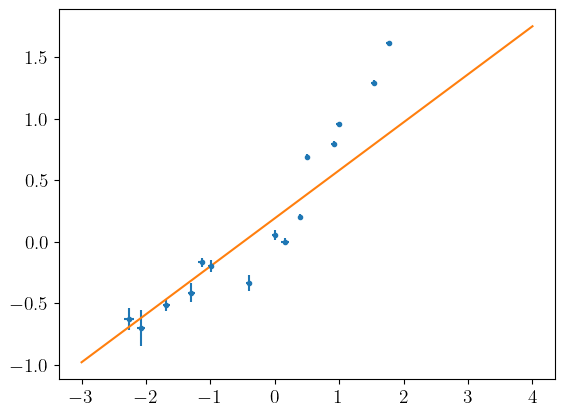

In [22]:
theta = [0.39, 0.19] # B, A
xplot = np.linspace(-3, 4, 100)
yplot = my_fun(xplot, theta)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".")
plt.plot(xplot,yplot)
plt.show()

# Broken line way 1

In [23]:
def my_broken_line(x, theta):
    B1, A1, B2, xtrans = theta
    A2 = (B1 - B2) * xtrans + A1  # enforce continuity

    y = jnp.where(
        x <= xtrans,
        B1 * x + A1,
        B2 * x + A2
    )
    return y

param_names = ['B1', 'A1', 'B2', 'xtrans']
theta0 = [0.2, 0.1, 1.0, 1.0]
param_prior = {'B1':[0, 2], 'A1':[-2, 2], 'B2':[0,2], 'xtrans':[-3,4], 'sig':[0, 3.0]}

reg = RoxyRegressor(my_broken_line, param_names, theta0, param_prior)

In [24]:
nwarm, nsamp = 700, 5000
samples = reg.mcmc(param_names, x, y, [xerr, yerr], nwarm, nsamp, method='mnr')


Optimisation Results:
B1:	0.5384142994880676
A1:	0.30111822485923767
B2:	0.933525800704956
xtrans:	3.019582748413086
sig:	0.22448772192001343
mu_gauss:	-0.23801474273204803
w_gauss:	1.2440130710601807

Running MCMC


sample: 100%|██████████| 5700/5700 [00:09<00:00, 581.80it/s, 31 steps of size 2.05e-01. acc. prob=0.91]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
        A1     -0.04      0.15     -0.03     -0.33      0.25    682.04      1.01
        B1      0.27      0.10      0.27      0.06      0.47    592.12      1.01
        B2      0.92      0.16      0.90      0.65      1.19    552.51      1.00
  mu_gauss     -0.24      0.37     -0.24     -0.95      0.48   3458.29      1.00
       sig      0.15      0.05      0.14      0.08      0.24    763.21      1.00
   w_gauss      1.42      0.30      1.37      0.90      2.01   3986.16      1.00
    xtrans      0.02      0.51     -0.04     -0.74      0.73    219.02      1.01

Number of divergences: 0


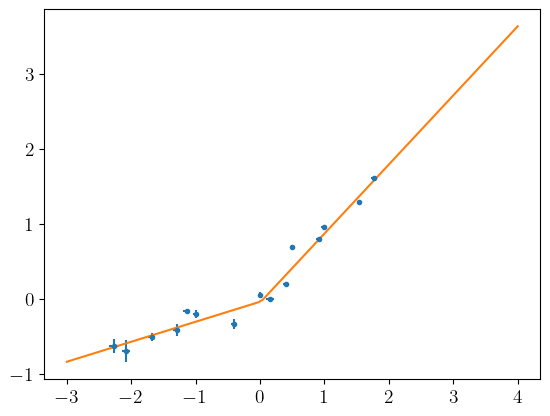

In [25]:
theta = [np.mean(samples['B1']).item(), np.mean(samples['A1']).item(), np.mean(samples['B2']).item(),  np.mean(samples['xtrans']).item()] # B1, A1, B2, xtrans
xplot = np.linspace(-3, 4, 100)
yplot = my_broken_line(xplot, theta)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".")
plt.plot(xplot,yplot)
plt.show()

In [26]:
param_order = ['B1', 'A1', 'B2', 'xtrans']
theta_array = np.vstack([samples[p] for p in param_order]).T  # shape: (nsamp, n_params)

negloglike = reg.negloglike 

loglike_vals = np.array([
    -negloglike(theta, x, y, [xerr, yerr])
    for theta in theta_array
])

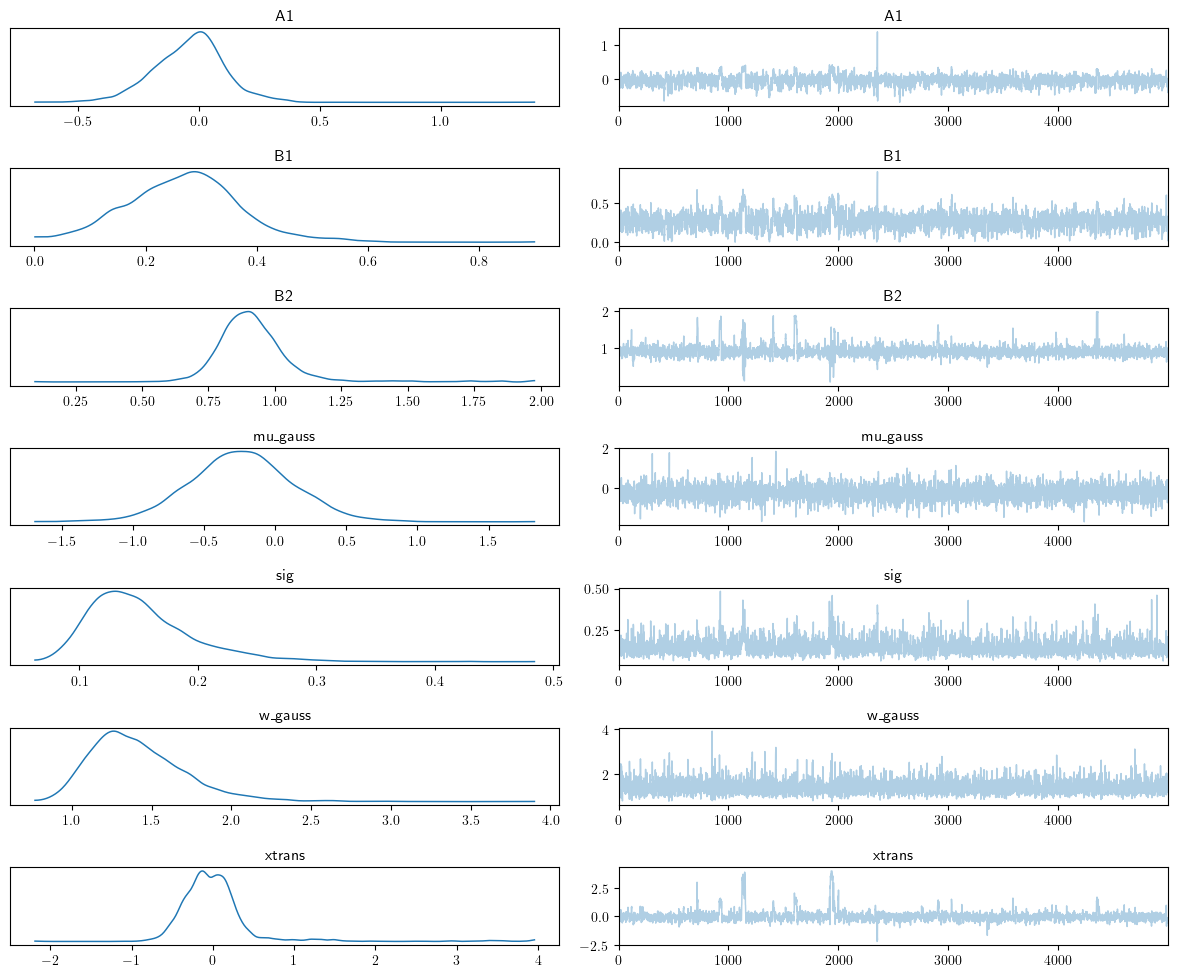

Removed no burn in


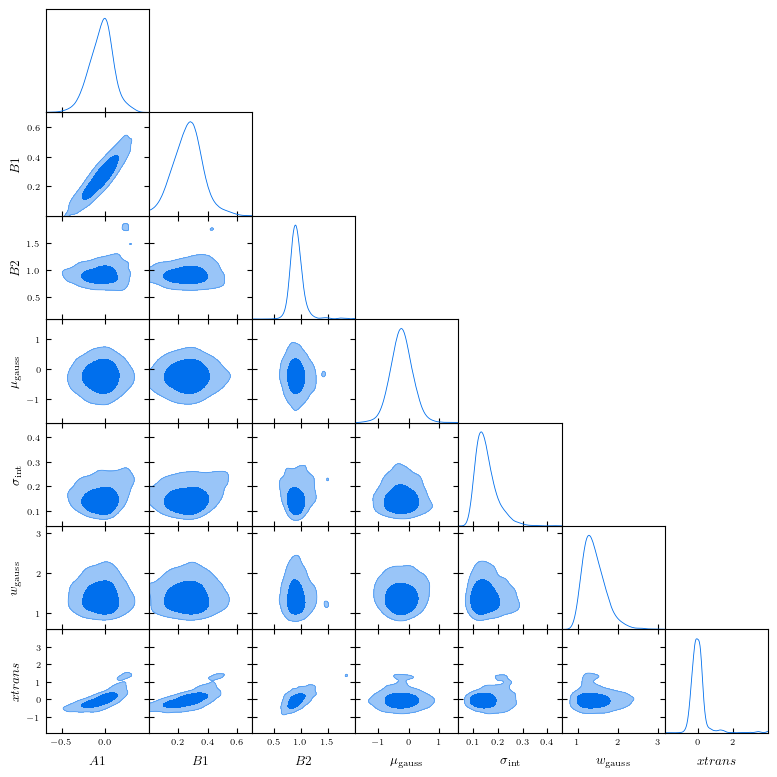

In [27]:
roxy.plotting.trace_plot(samples, to_plot='all')
roxy.plotting.triangle_plot(samples, to_plot='all', module='getdist', param_prior=param_prior)
#roxy.plotting.posterior_predictive_plot(reg, samples, x, y, xerr, yerr)

In [ ]:
max_ngauss = 3
np.random.seed(42)
reg.find_best_gmm(param_names, x, y, xerr, yerr, max_ngauss, best_metric='BIC', nwarm=100, nsamp=100, gmm_prior='hierarchical')

# Broken line way 2

In [29]:
# Second method for the 2-line function

def my_broken_line_way2(x, theta):
    B1, B2, xtrans, ytrans = theta

    y = jnp.where(
        x <= xtrans,
        B1 * (x - xtrans) + ytrans,
        B2 * (x - xtrans) + ytrans
    )
    return y

param_names = ['B1', 'B2', 'xtrans', 'ytrans']
theta0 = [0.2, 1.0, 1.0, 0.5]
param_prior = {'B1':[0, 2], 'B2':[0,2], 'xtrans':[-3,4], 'ytrans': [-1,3], 'sig':[0, 3.0]}

reg = RoxyRegressor(my_broken_line_way2, param_names, theta0, param_prior)


In [30]:
nwarm, nsamp = 700, 5000
samples = reg.mcmc(param_names, x, y, [xerr, yerr], nwarm, nsamp, method='mnr')


Optimisation Results:
B1:	0.28147393465042114
B2:	0.9170974493026733
xtrans:	0.035233061760663986
ytrans:	0.00613692682236433
sig:	0.10924669355154037
mu_gauss:	-0.23937688767910004
w_gauss:	1.2452101707458496

Running MCMC


sample: 100%|██████████| 5700/5700 [00:11<00:00, 485.62it/s, 31 steps of size 1.36e-01. acc. prob=0.92]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
        B1      0.26      0.11      0.26      0.06      0.44   1007.01      1.00
        B2      0.90      0.11      0.90      0.69      1.13   1786.16      1.00
  mu_gauss     -0.25      0.38     -0.24     -1.03      0.46   3108.35      1.00
       sig      0.15      0.04      0.14      0.08      0.24   1427.52      1.00
   w_gauss      1.42      0.30      1.37      0.91      2.03   3279.78      1.00
    xtrans     -0.06      0.36     -0.07     -0.66      0.49    658.41      1.00
    ytrans     -0.05      0.23     -0.06     -0.47      0.31    754.41      1.00

Number of divergences: 0


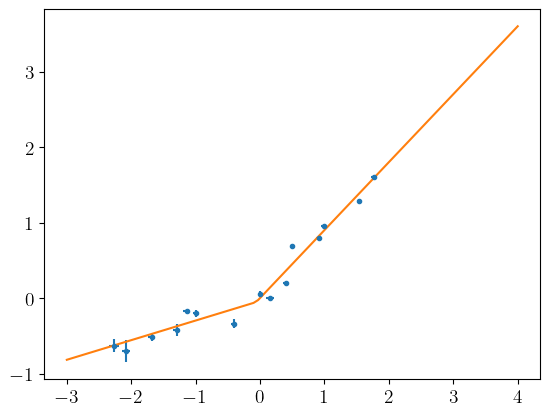

In [32]:
theta = [0.26,  0.90, -0.06,  -0.05] # B1, B2, xtrans, ytrans
xplot = np.linspace(-3, 4, 100)
yplot = my_broken_line_way2(xplot, theta)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".")
plt.plot(xplot,yplot)
plt.show()